# HOMEWORK PART 1

---

1. Develop a DMD model to forecast the future population states.
2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.
3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.
4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.


In [144]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.linalg import hankel
import sklearn
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from scipy import integrate

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42

In [145]:
data_dict = {'Year': [], 'Snowshow Hare': [], 'Canada Lynx': []}
dt = 2
years = np.arange(1845, 1903 + dt, dt)
time = np.arange(0, 1903 - 1845 + dt, dt)
SH = np.array([20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70,
               100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65])
CL = np.array([32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 
               34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 25])

data_dict['Years'] = years
data_dict['Snowshow Hare'] = SH
data_dict['Canada Lynx'] = CL

## Part 1: Develop a DMD model to forecast the future population states.

In [146]:
f_SH = interp1d(time, SH, kind='cubic')
f_CL = interp1d(time, CL, kind='cubic')

dt_new = 0.1
years_new = np.arange(1845, 1903 + dt_new, dt_new)
t_new = np.arange(0, 1903 - 1845 + dt_new, dt_new)
SH_new = f_SH(t_new)
tmp = SH_new <= 1
SH_new[tmp] = 1
CL_new = f_CL(t_new)
tmp = CL_new <= 1
CL_new[tmp] = 1

In [147]:
SH.shape, SH_new.shape

((30,), (581,))

<IPython.core.display.Javascript object>


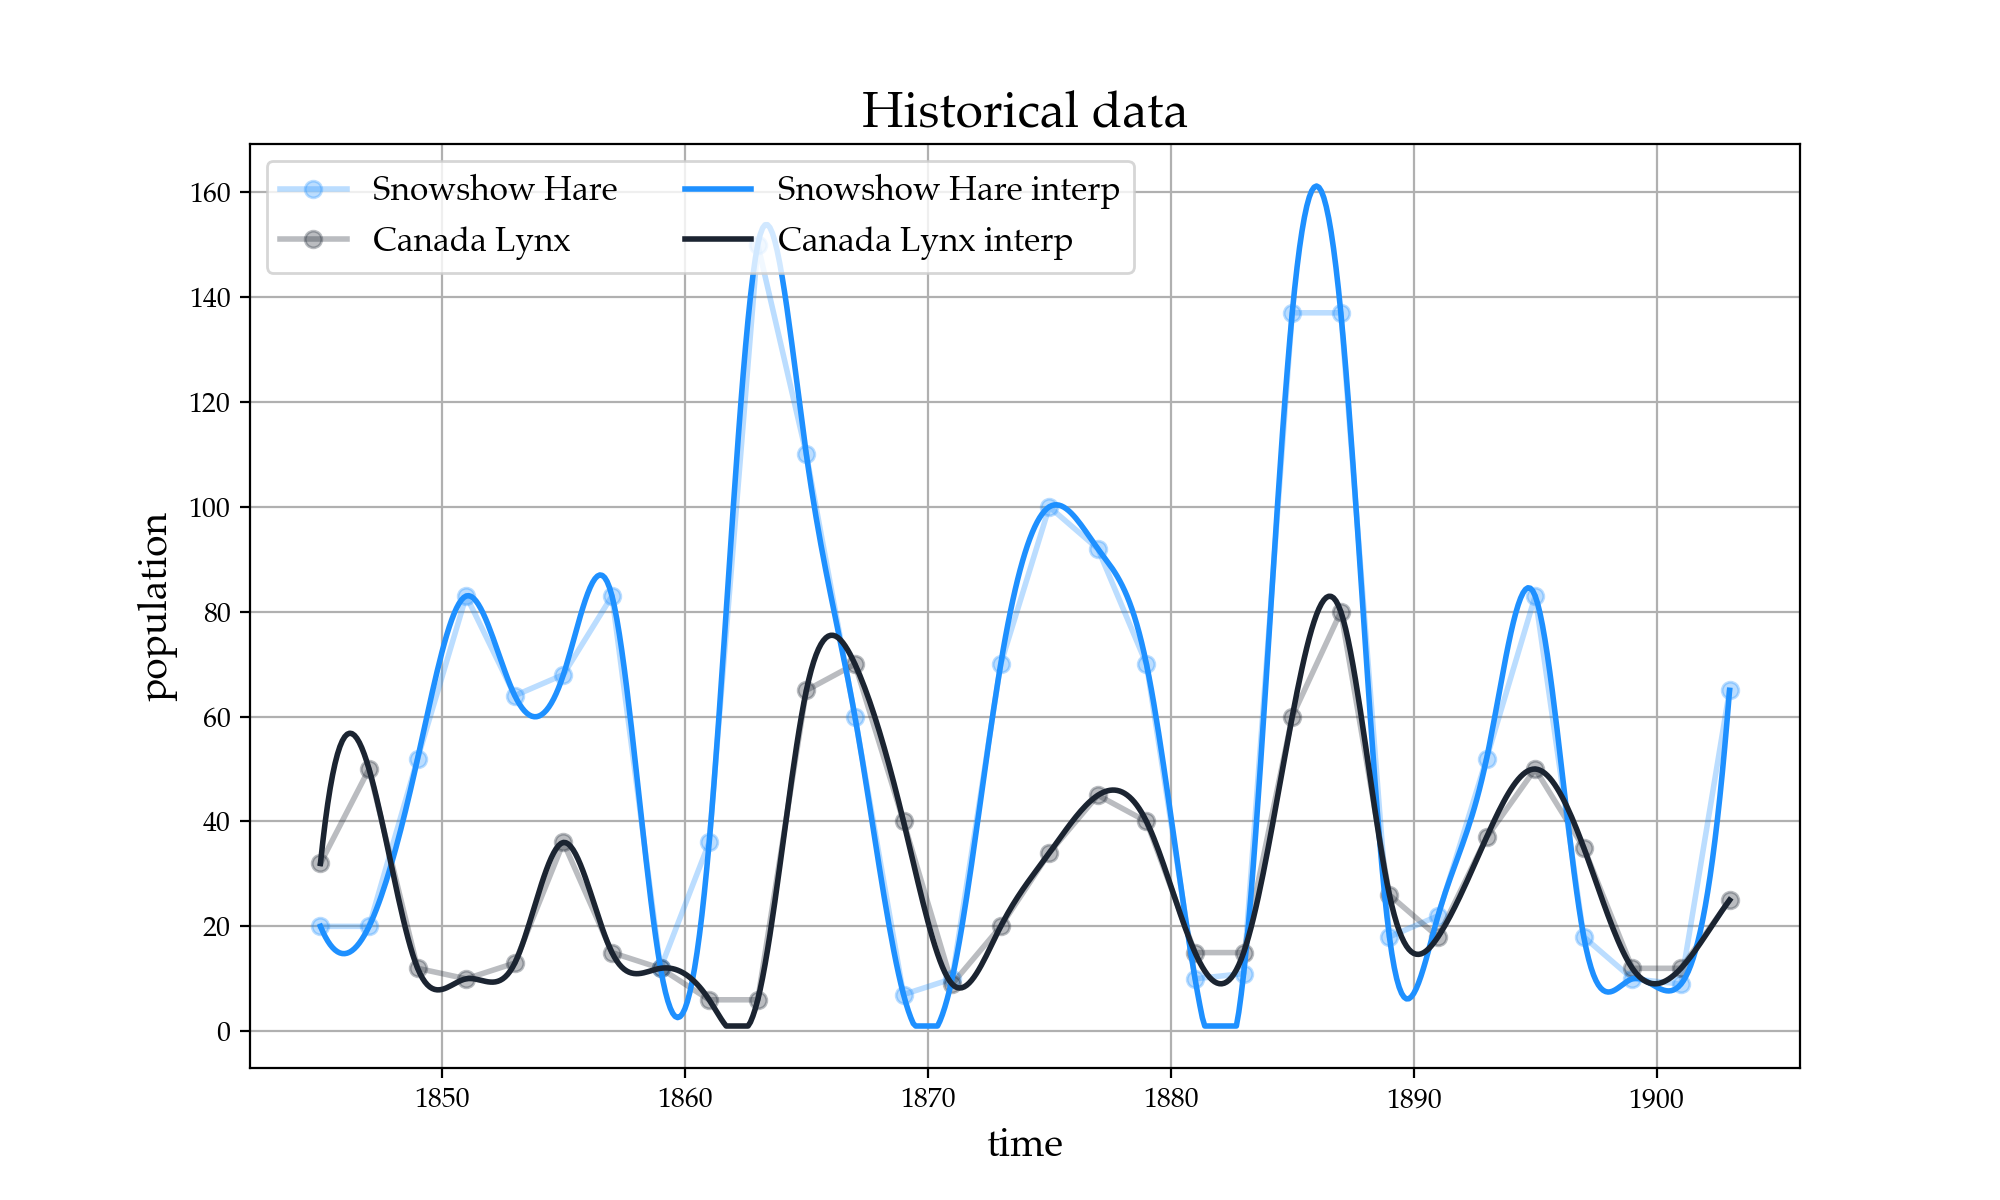

In [148]:
fig = plt.figure(figsize=(10, 6))
plt.plot(years, SH, '-o', linewidth='2', color='dodgerblue', alpha=.3)
plt.plot(years, CL, '-o', linewidth='2', color='xkcd:dark', alpha=.3)
plt.plot(years_new, SH_new, color='dodgerblue')
plt.plot(years_new, CL_new, color='xkcd:dark')
plt.title('Historical data', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx', 'Snowshow Hare interp', 'Canada Lynx interp'], fontsize = 12, ncol=2)
plt.grid(True, which="both")
fig.savefig('figures/population_data.pdf', format='pdf', dpi=1200)

In [150]:
data = np.vstack((SH, CL))
X = data[:, :-1]
dX = data[:, 1:]

n_test = int(X.shape[1] * 0.2)

# Train and test
X_train = X[:, :-n_test]
dX_train = dX[:, :-n_test]
X_test = X[:, -n_test:]
dX_test = dX[:, -n_test:]

In [151]:
print("Size of matrix X_train: {}x{} ".format(X_train.shape[0], X_train.shape[1]))

Size of matrix X_train: 2x24 


In [152]:
# Full SVD
U, S, V = np.linalg.svd(X_train, full_matrices=True)
print('Full SVD')
print("Size of matrix U: {}x{} ".format(U.shape[0], U.shape[1]))
print("Size of matrix V: {}x{} ".format(V.shape[0], V.shape[1]))

Full SVD
Size of matrix U: 2x2 
Size of matrix V: 24x24 


In [153]:
# Economy SVD
r = 2
U, S, V = np.linalg.svd(X_train, full_matrices=False)
U = U[:, :r]
V = V[:r, :]
V = V.T # np.linalg gives the cognugate transpose
S = S[:r]
print('Economy SVD')
print("Size of matrix U: {}x{} ".format(U.shape[0], U.shape[1]))
print("Size of matrix V: {}x{} ".format(V.shape[0], V.shape[1]))

Economy SVD
Size of matrix U: 2x2 
Size of matrix V: 24x2 


<IPython.core.display.Javascript object>


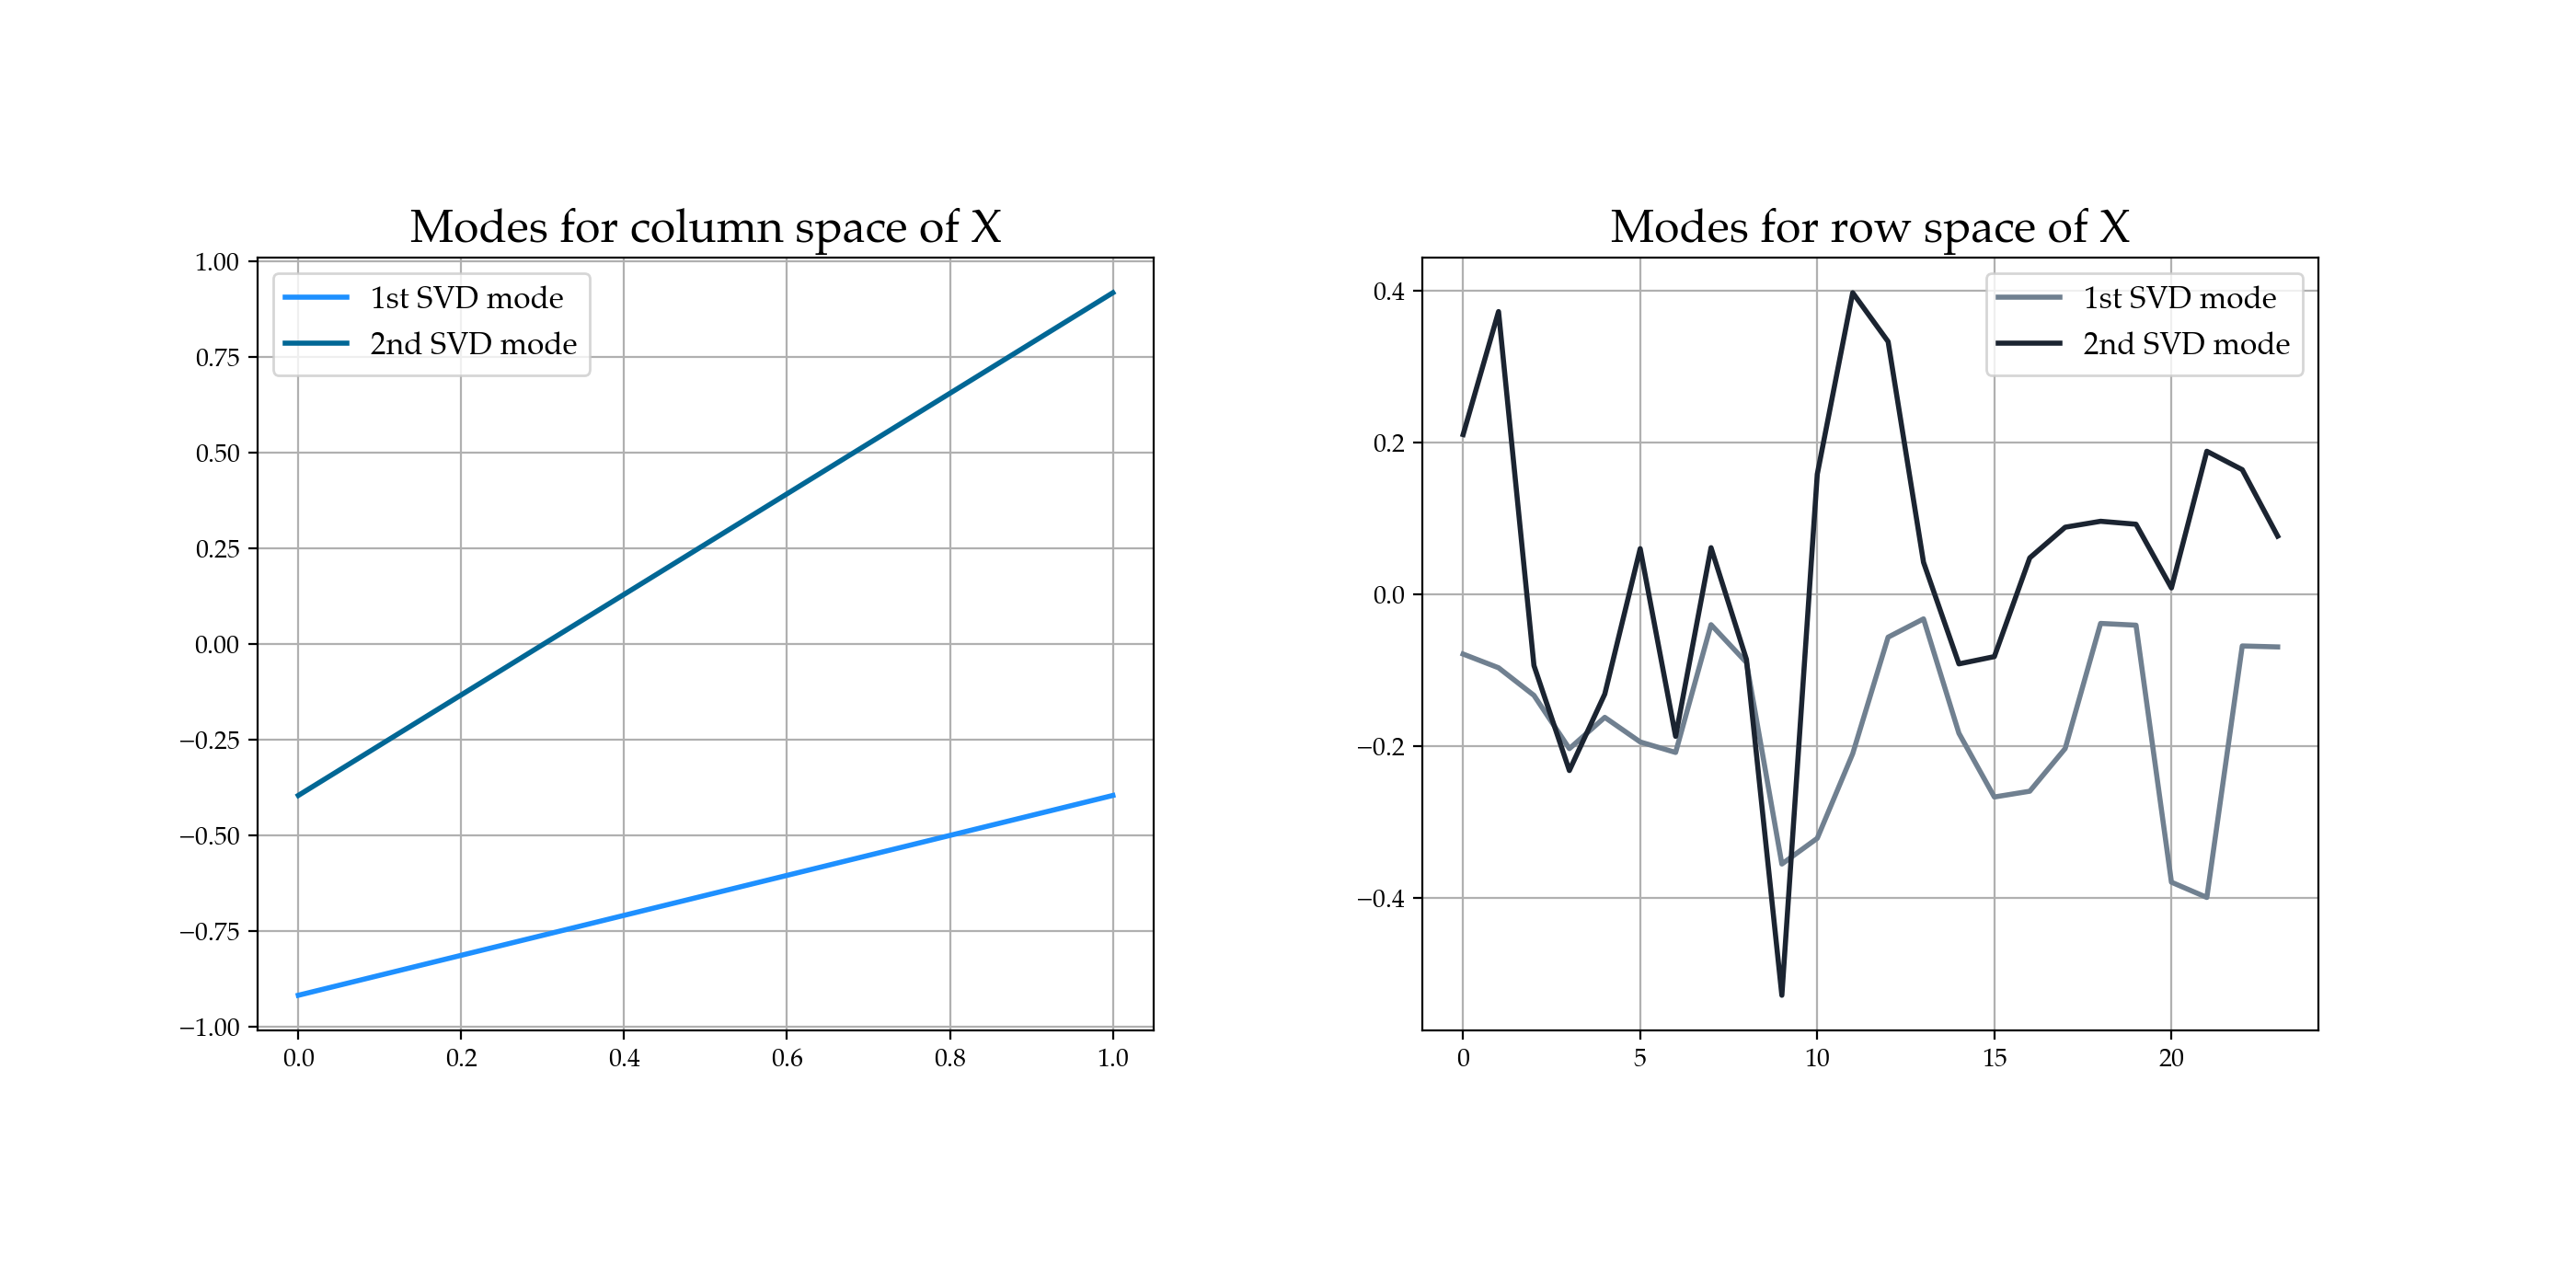

In [154]:
fig = plt.figure(figsize=(14, 7))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(np.real(U[:, 0]), linewidth='2', color='dodgerblue')
h = ax.plot(np.real(U[:, 1]), linewidth='2', color='xkcd:peacock blue')
ax.set_title('Modes for column space of X', fontsize = 18)
ax.legend(['1st SVD mode', '2nd SVD mode'], fontsize = 12)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(np.real(V[:, 0]), linewidth='2', color='slategray')
h = ax.plot(np.real(V[:, 1]), linewidth='2', color='xkcd:dark')
ax.set_title('Modes for row space of X', fontsize = 18)
ax.legend(['1st SVD mode', '2nd SVD mode'], fontsize = 12)
ax.grid()

<IPython.core.display.Javascript object>


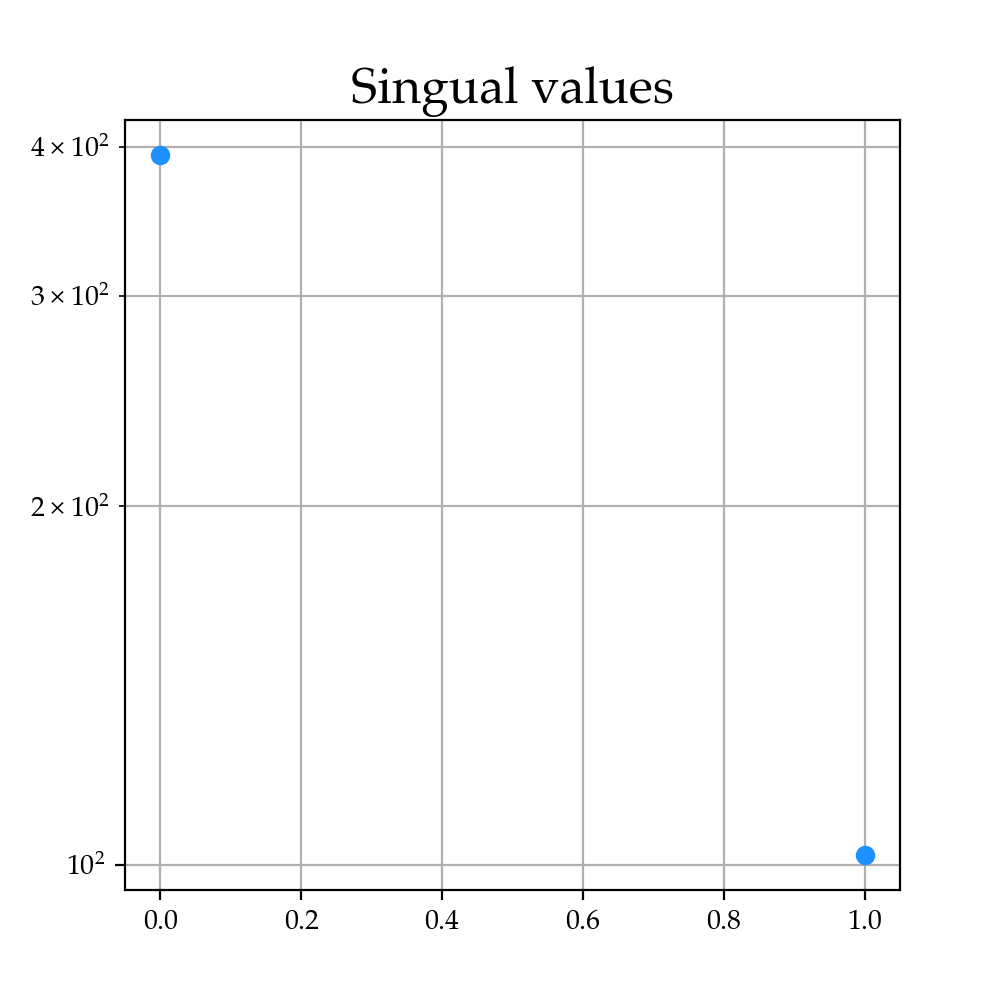

In [19]:
fig = plt.figure(figsize=(5, 5))
plt.plot(range(len(S)), S, 'o', linewidth='2', color='dodgerblue')
plt.yscale('log')
plt.title('Singual values', fontsize = 18)
plt.grid(True, which="both")

In [155]:
A_tilde = U.T @ dX_train @ V @ np.linalg.inv(np.diag(S))
Lambda, W = np.linalg.eig(A_tilde)
Phi = dX_train @ V @ np.linalg.inv(np.diag(S)) @ W

In [156]:
X1 = X[:, 0]
omega = np.log(Lambda) / dt

b = np.dot(np.linalg.pinv(Phi), X1)

In [157]:
x_k = np.zeros((r, len(time)), dtype=omega.dtype)
for k in range(len(time)):
    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b

x_dmd = np.zeros((r, len(time)), dtype=omega.dtype)
for k in range(len(time)):
    x_dmd[:, k] = b * np.exp(omega*time[k])
x_dmd = np.dot(Phi, x_dmd)

<IPython.core.display.Javascript object>


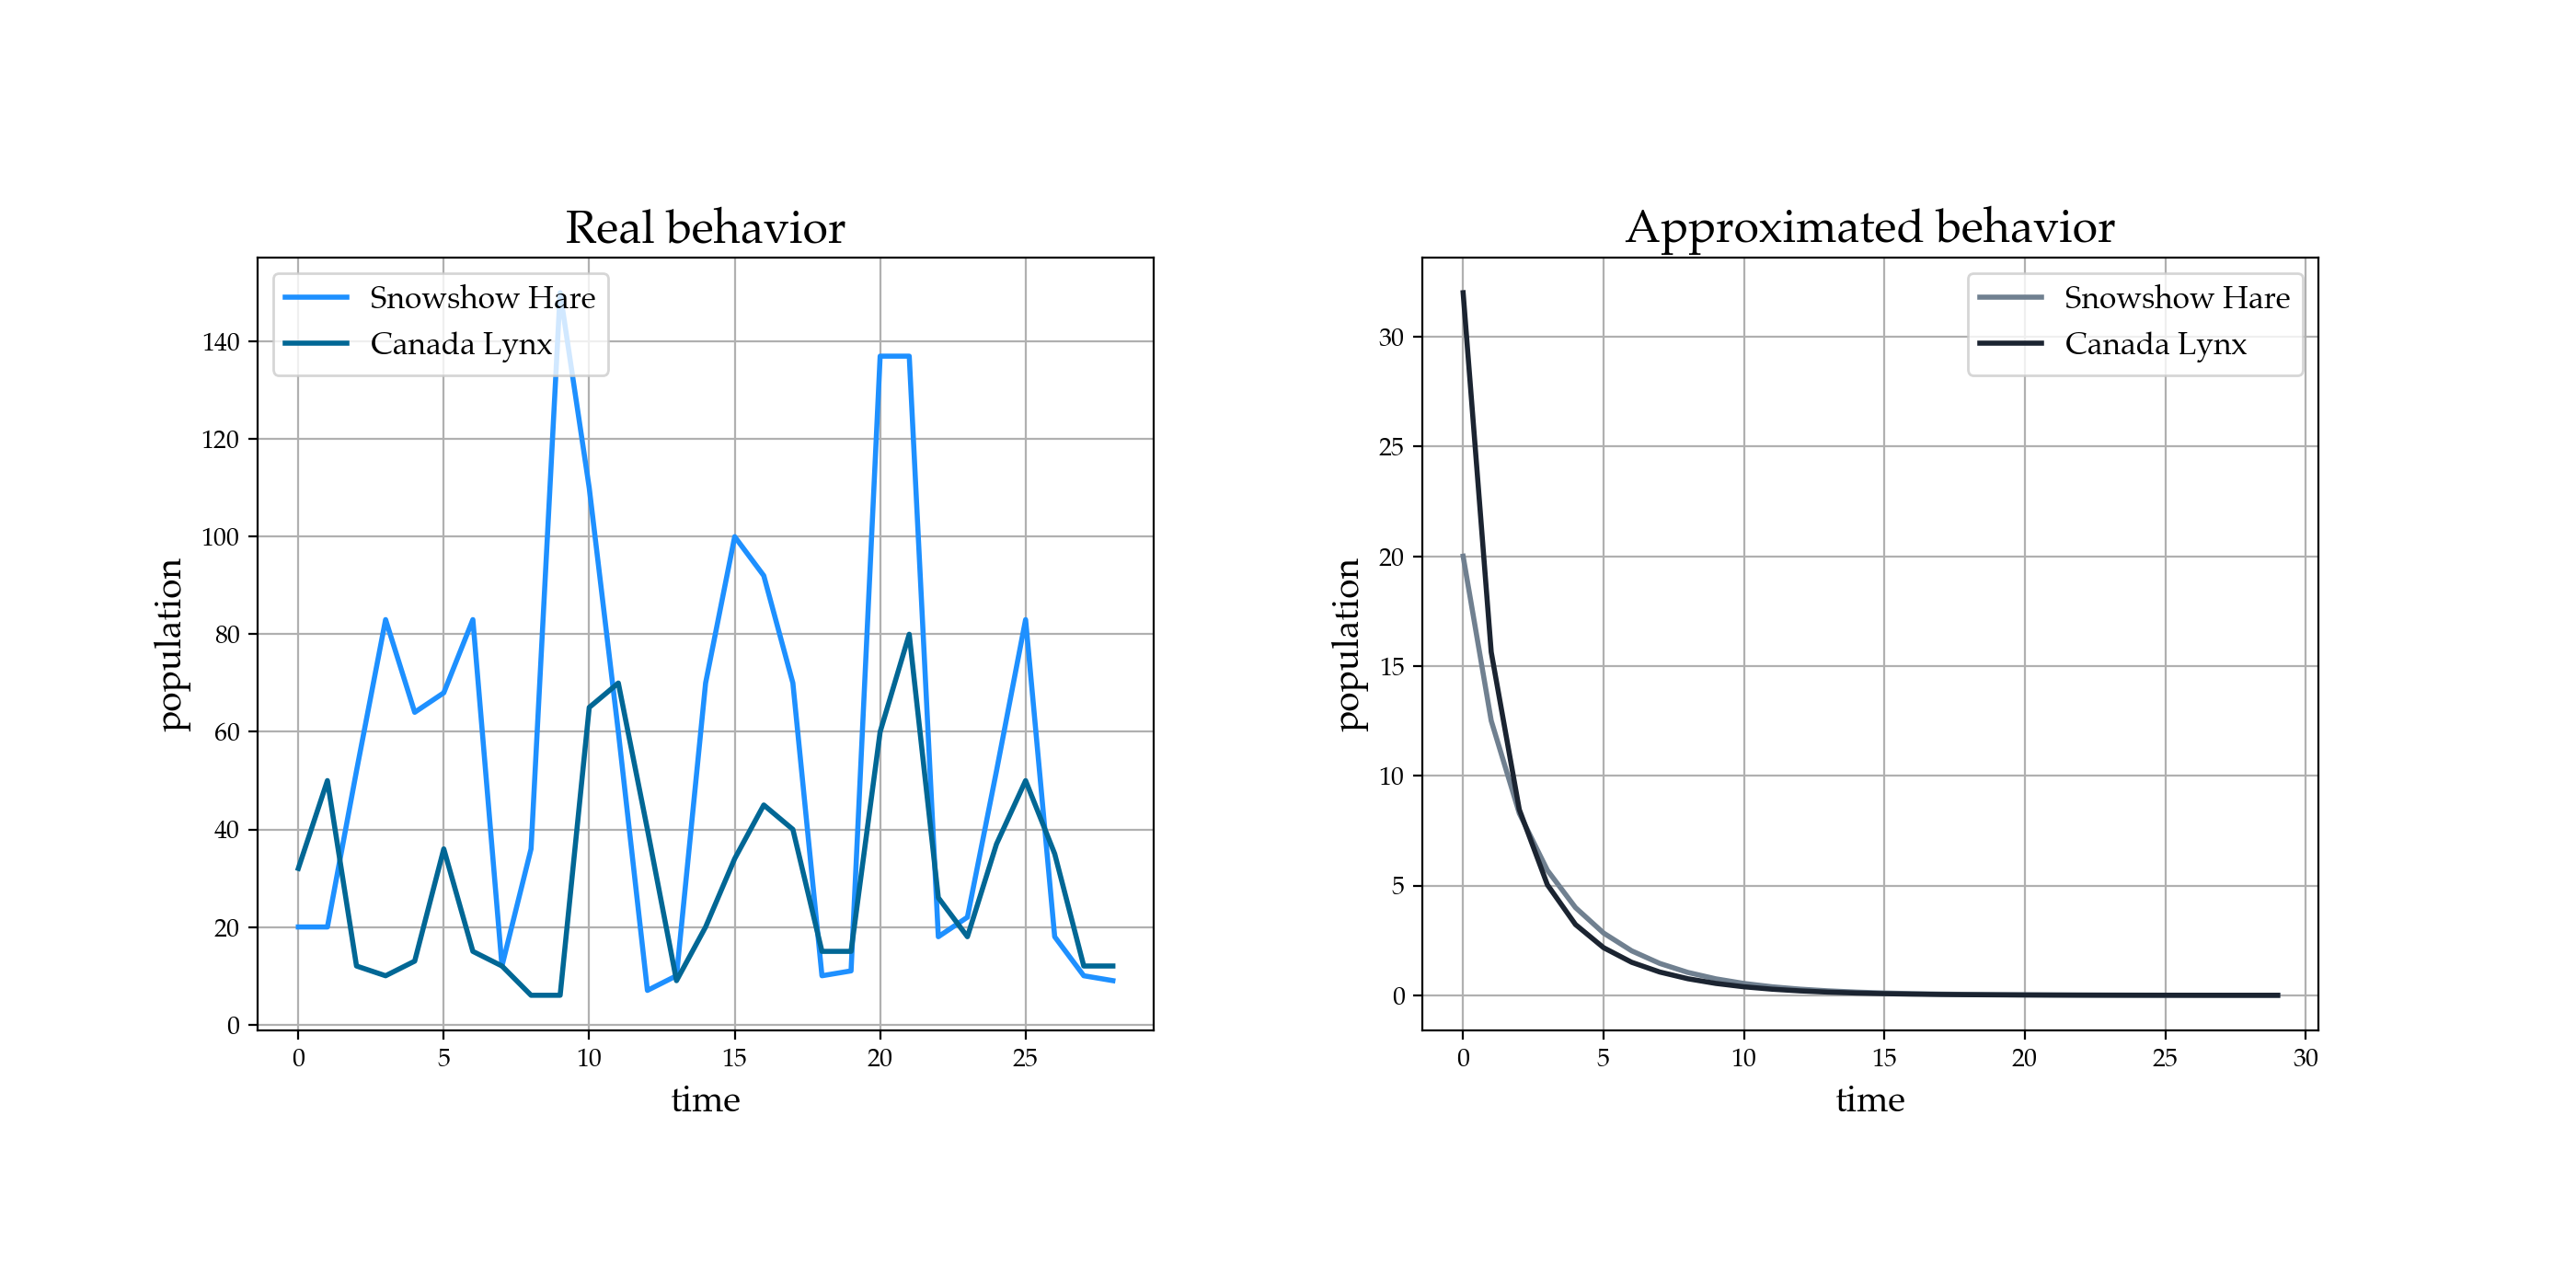

In [158]:
fig = plt.figure(figsize=(14, 7))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(X[0, :], linewidth='2', color='dodgerblue')
h = ax.plot(X[1, :], linewidth='2', color='xkcd:peacock blue')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(np.real(x_dmd[0, :]), linewidth='2', color='slategray')
h = ax.plot(np.real(x_dmd[1, :]), linewidth='2', color='xkcd:dark')
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12)
ax.grid()

Now we will repeat the same procedure but increasing the samples by interpolating the few sample points.

In [159]:
data = np.vstack((SH_new, CL_new))

X = data[:, :-1]
dX = data[:, 1:]

r = 2
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T # general
U = U[:, :r]
V = V[:, :r]
S = S[:r]

In [163]:
A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
Lambda, W = np.linalg.eig(A_tilde)
Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W

X0 = X[:, 0] # initial conditions

omega = np.log(Lambda) / dt_new

b = np.linalg.pinv(Phi) @ X0

In [164]:
x_k = np.zeros((r, len(t_new)), dtype=omega.dtype)
for k in range(len(t_new)):
    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b

x_dmd = np.zeros((r, len(t_new)), dtype=omega.dtype)
for k in range(len(t_new)):
    x_dmd[:, k] = b * np.exp(omega*t_new[k])
x_dmd = np.dot(Phi, x_dmd)

<IPython.core.display.Javascript object>


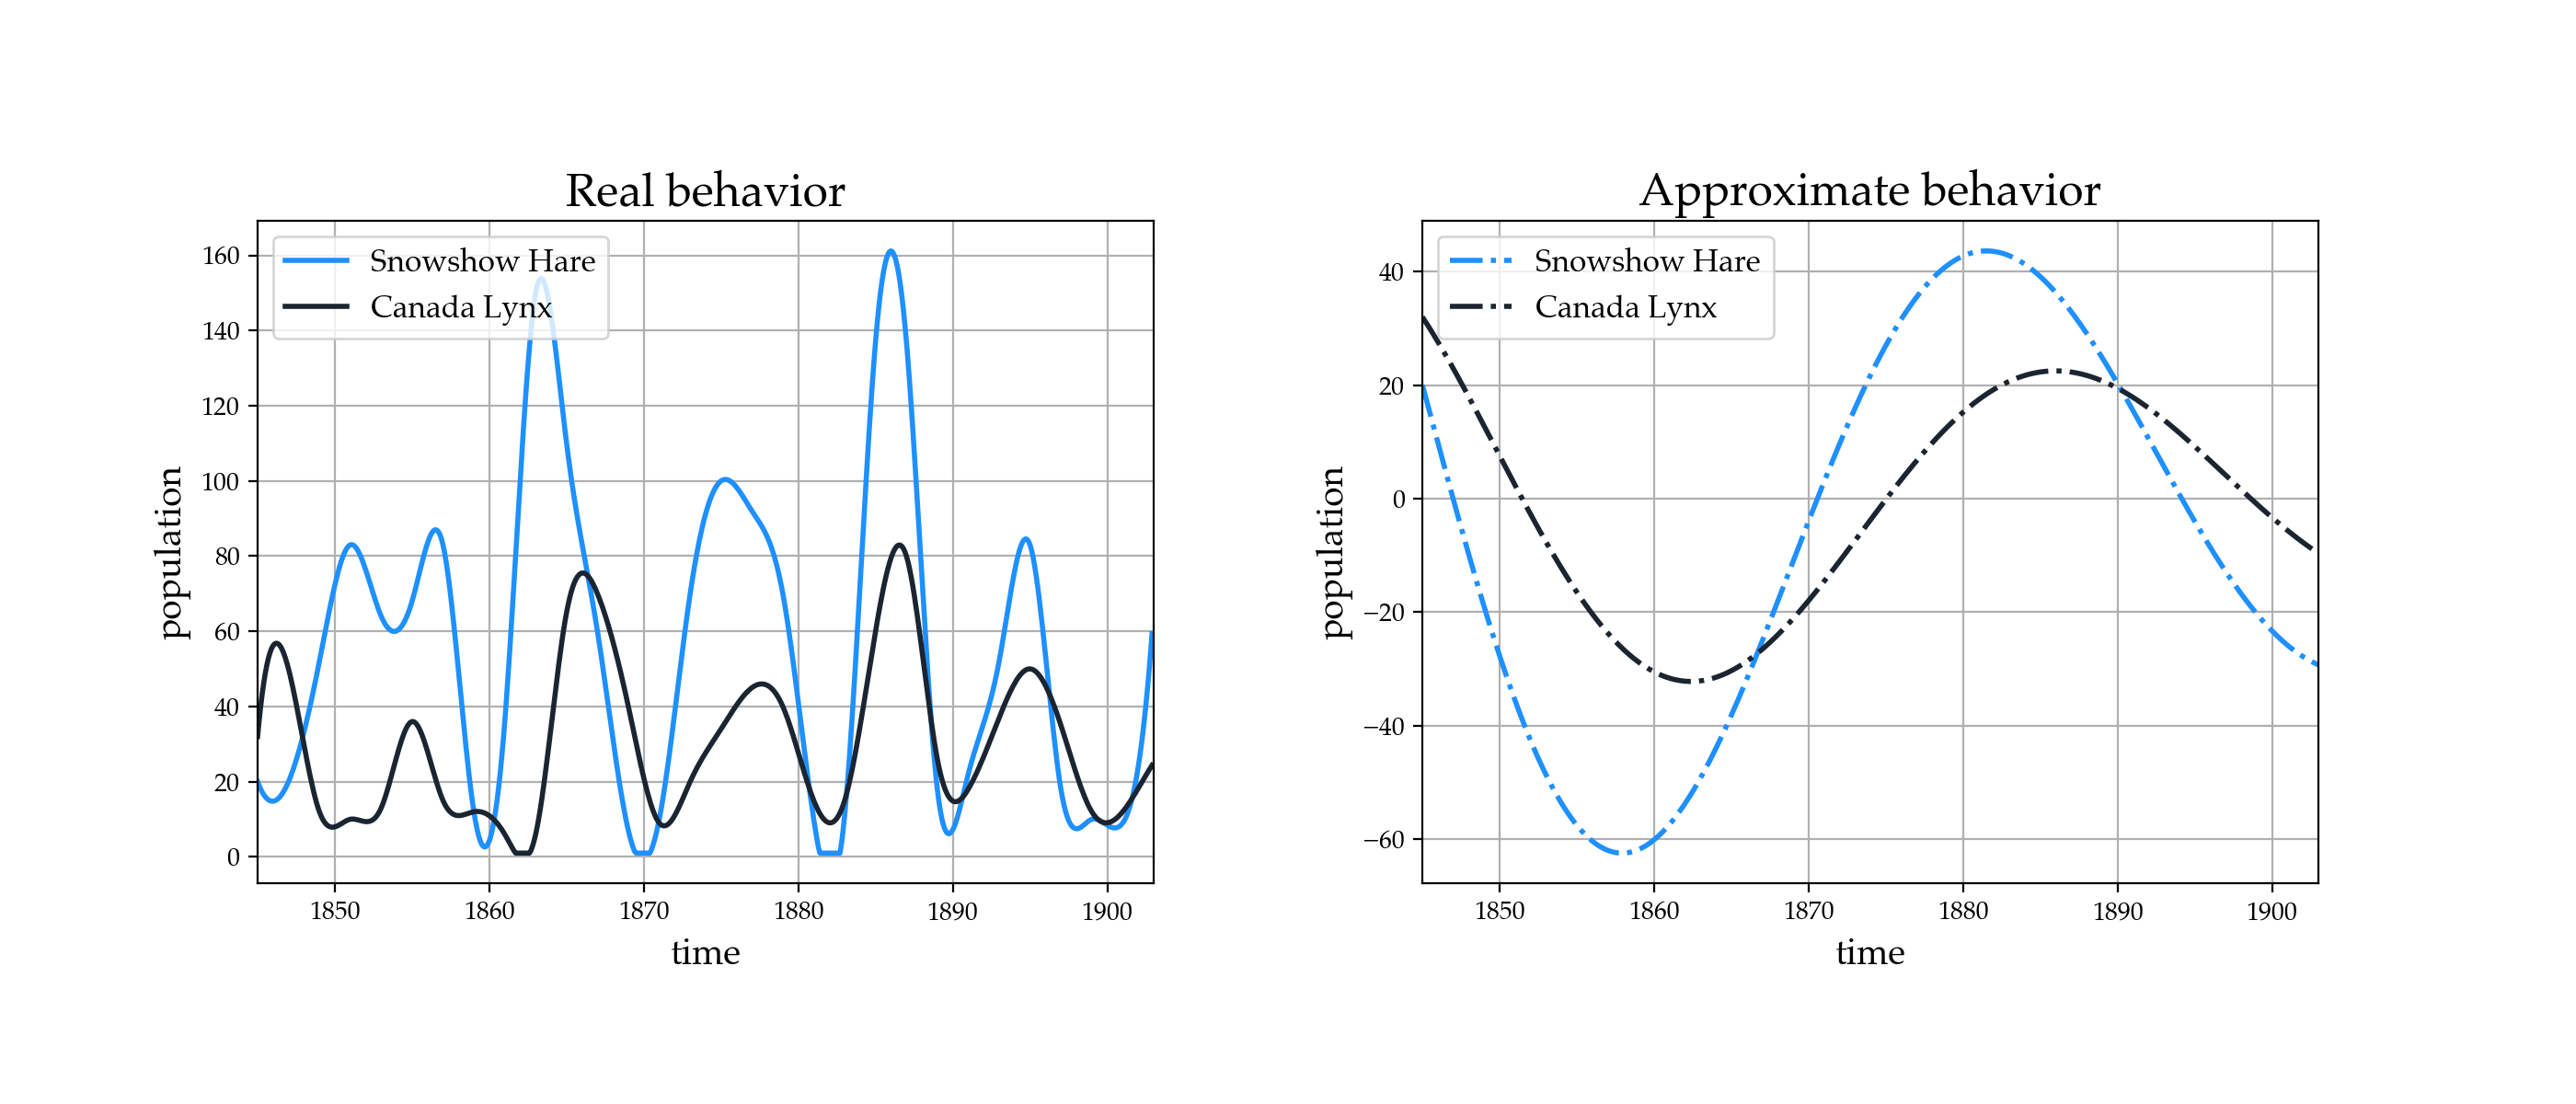

In [165]:
fig = plt.figure(figsize=(14, 6))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:-1], X[0, :], linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:-1], X[1, :], linewidth='2', color='xkcd:dark')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new, np.real(x_dmd[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new, np.real(x_dmd[1, :]), '-.', linewidth='2', color='xkcd:dark')
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()
fig.savefig('figures/dmd.pdf', format='pdf', dpi=1200)

## Part 2: Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

In [166]:
print("We have a total of {} time samples".format(data.shape[1]))

We have a total of 581 time samples


In [167]:
n_emb = 5
t_start = 400
H1 = data[:, :t_start]
dH1 = data[:, 1:t_start+1]
for i in range(1, n_emb):
    H1 = np.vstack((H1, data[:,i:t_start+i]))
    dH1 = np.vstack((dH1, data[:,i+1:t_start+i+1]))

In [168]:
n_emb = 50
t_start = 400
H2 = data[:, :t_start]
dH2 = data[:, 1:t_start+1]
for i in range(1, n_emb):
    H2 = np.vstack((H2, data[:,i:t_start+i]))
    dH2 = np.vstack((dH2, data[:,i+1:t_start+i+1]))

In [169]:
n_emb = 100
t_start = 400
H3 = data[:, :t_start]
dH3 = data[:, 1:t_start+1]
for i in range(1, n_emb):
    H3 = np.vstack((H3, data[:,i:t_start+i]))
    dH3 = np.vstack((dH3, data[:,i+1:t_start+i+1]))

In [170]:
H = hankel(data[:, :400])
Htmp = np.zeros_like(H)
Htmp[0::2, :] = H[:int(H.shape[0]/2),:]
Htmp[1::2, :] = H[int(H.shape[0]/2):,:]
H4 = Htmp[:, :-1]
dH4 = Htmp[:, 1:]

In [171]:
U1, S1, V1 = np.linalg.svd(H1, full_matrices=False)
U2, S2, V2 = np.linalg.svd(H2, full_matrices=False)
U3, S3, V3 = np.linalg.svd(H3, full_matrices=False)
U4, S4, V4 = np.linalg.svd(H4, full_matrices=False)

<IPython.core.display.Javascript object>


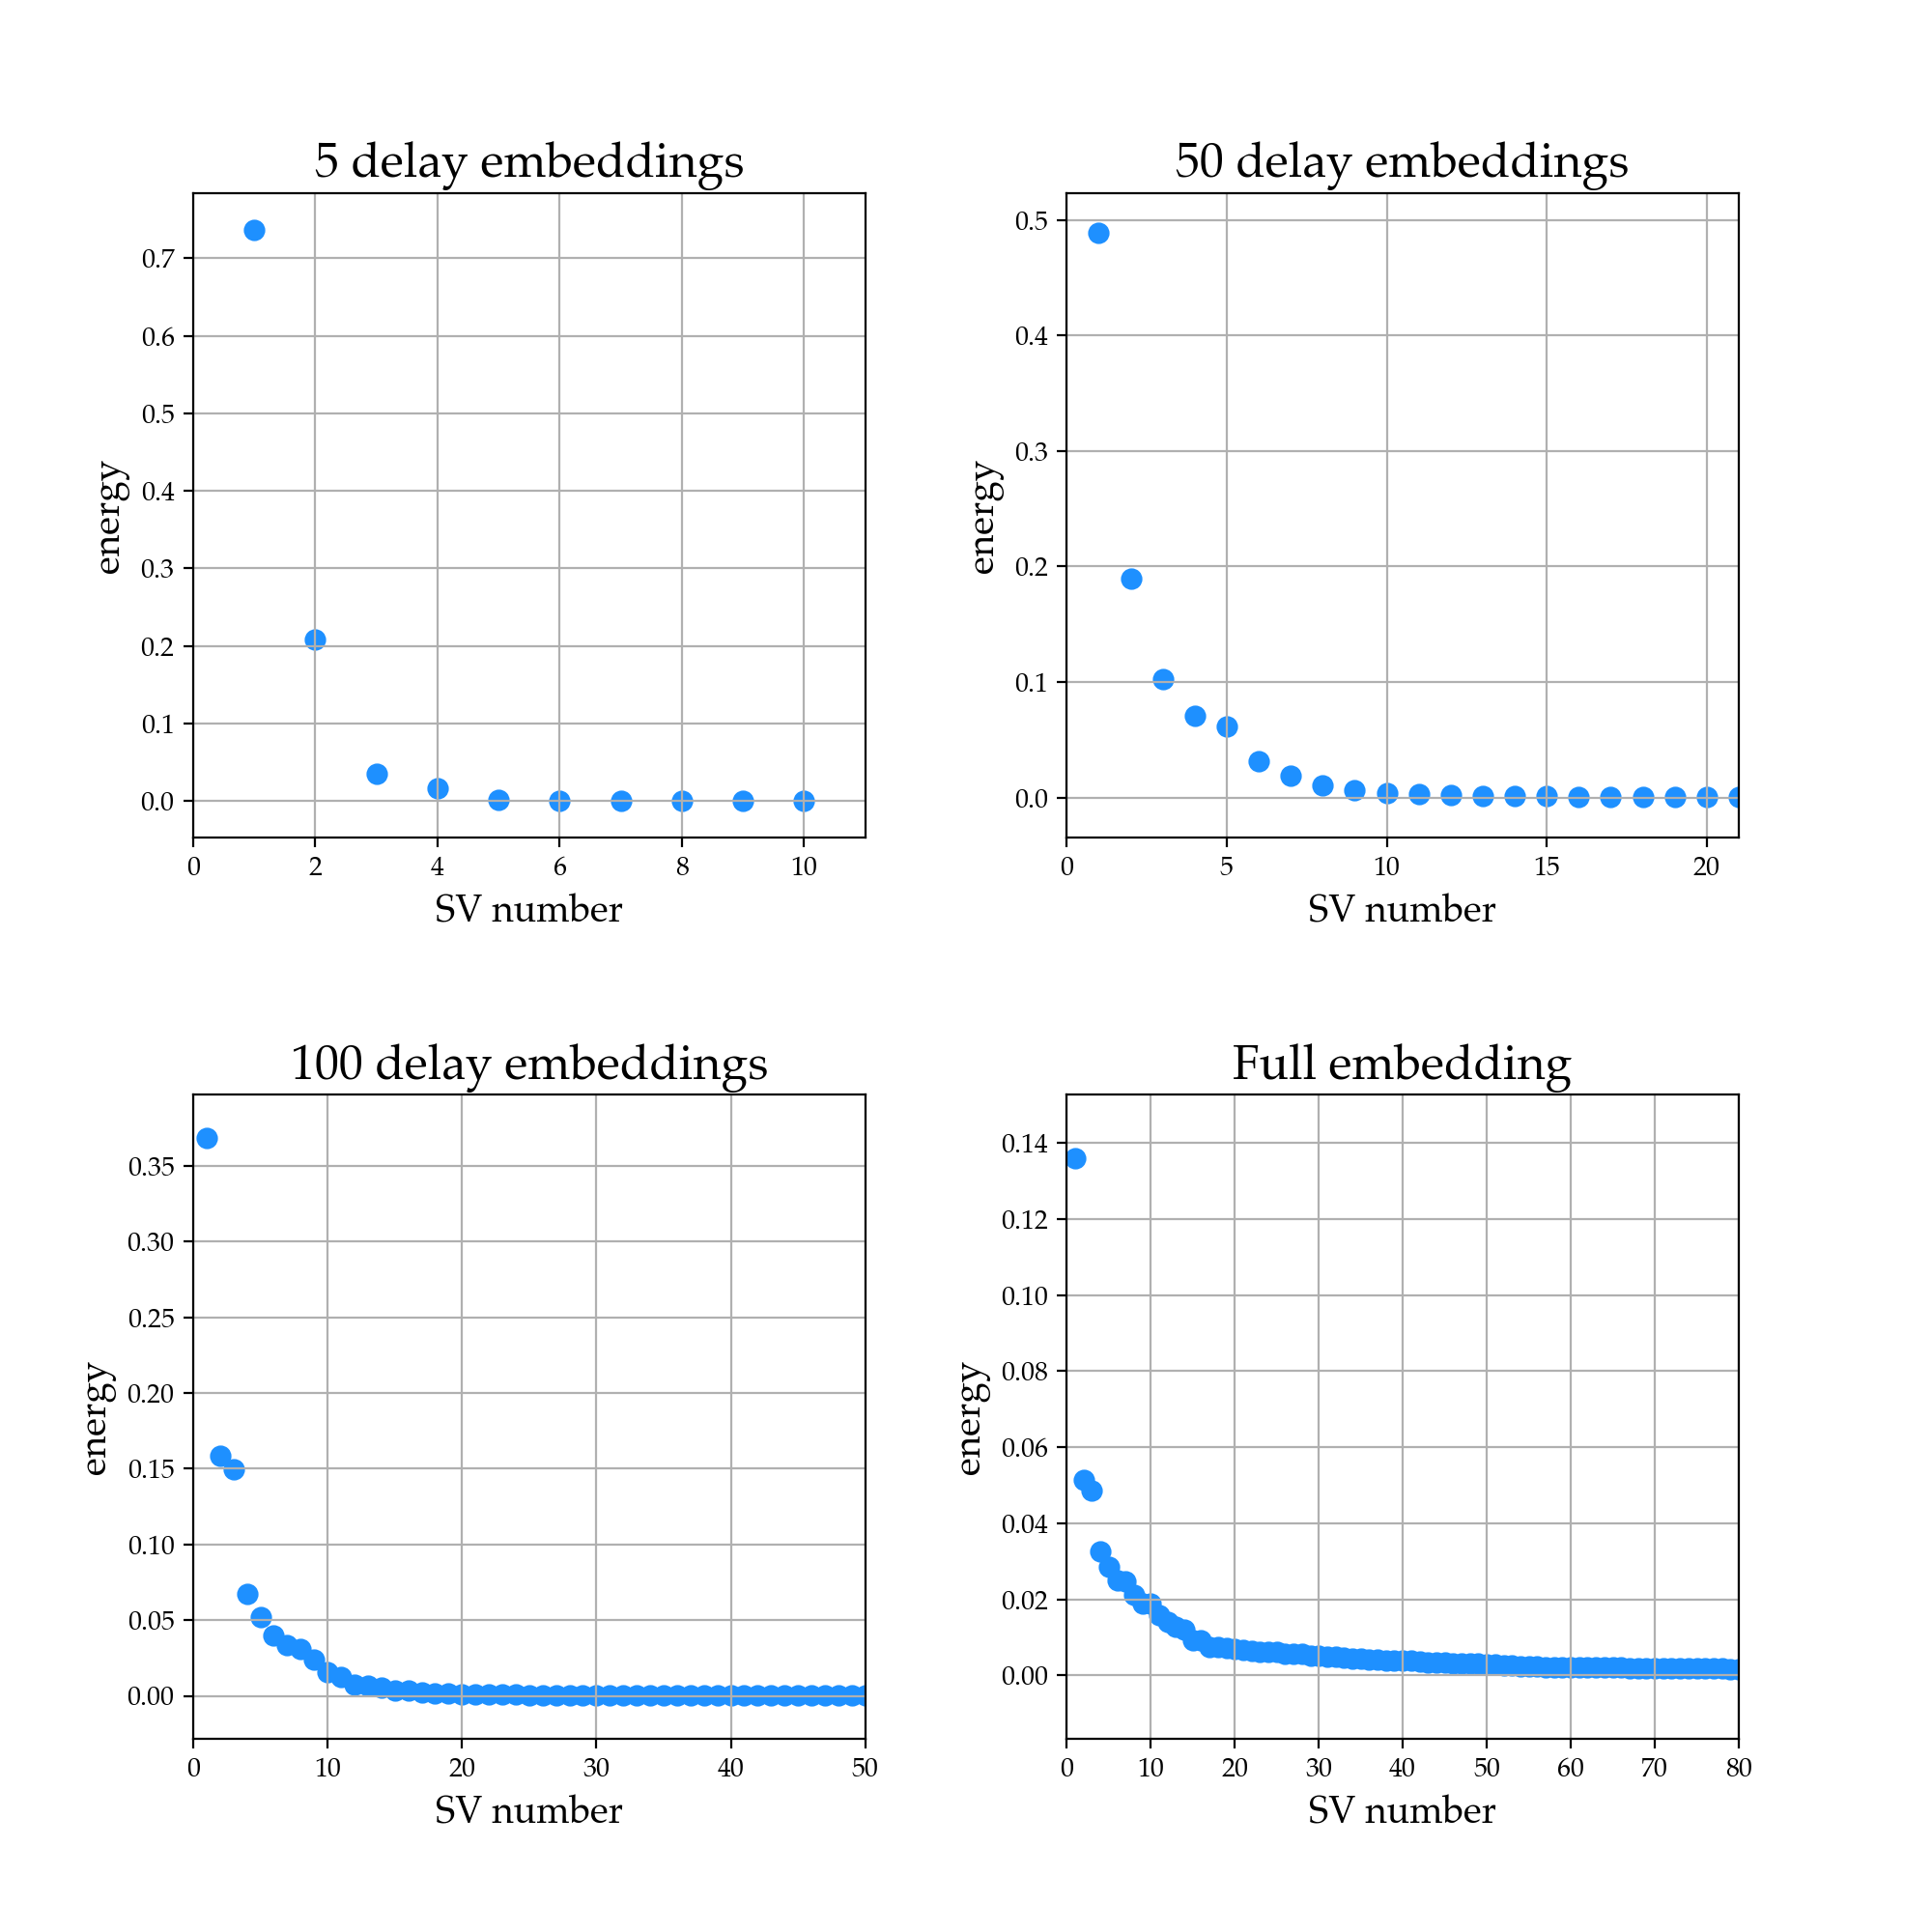

In [173]:
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.4)

ax = plt.subplot(gs[0, 0])
h = ax.scatter(range(1, len(S1)+1), S1 / np.sum(S1), linewidth='2', color='dodgerblue')
ax.set_title('5 delay embeddings', fontsize = 18)
ax.set_xlim([0, 11])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.scatter(range(1, len(S2)+1), S2 / np.sum(S2), linewidth='2', color='dodgerblue')
ax.set_title('50 delay embeddings', fontsize = 18)
ax.set_xlim([0, 21])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.scatter(range(1, len(S3)+1), S3 / np.sum(S3), linewidth='2', color='dodgerblue')
ax.set_title('100 delay embeddings', fontsize = 18)
ax.set_xlim([0, 50])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

ax = plt.subplot(gs[1, 1])
h = ax.scatter(range(1, len(S4)+1), S4 / np.sum(S4), linewidth='2', color='dodgerblue')
ax.set_title('Full embedding', fontsize = 18)
ax.set_xlim([0, 80])
plt.xlabel('SV number', fontsize = 14)
plt.ylabel('energy', fontsize = 14)
ax.grid()

fig.savefig('figures/td_energy.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


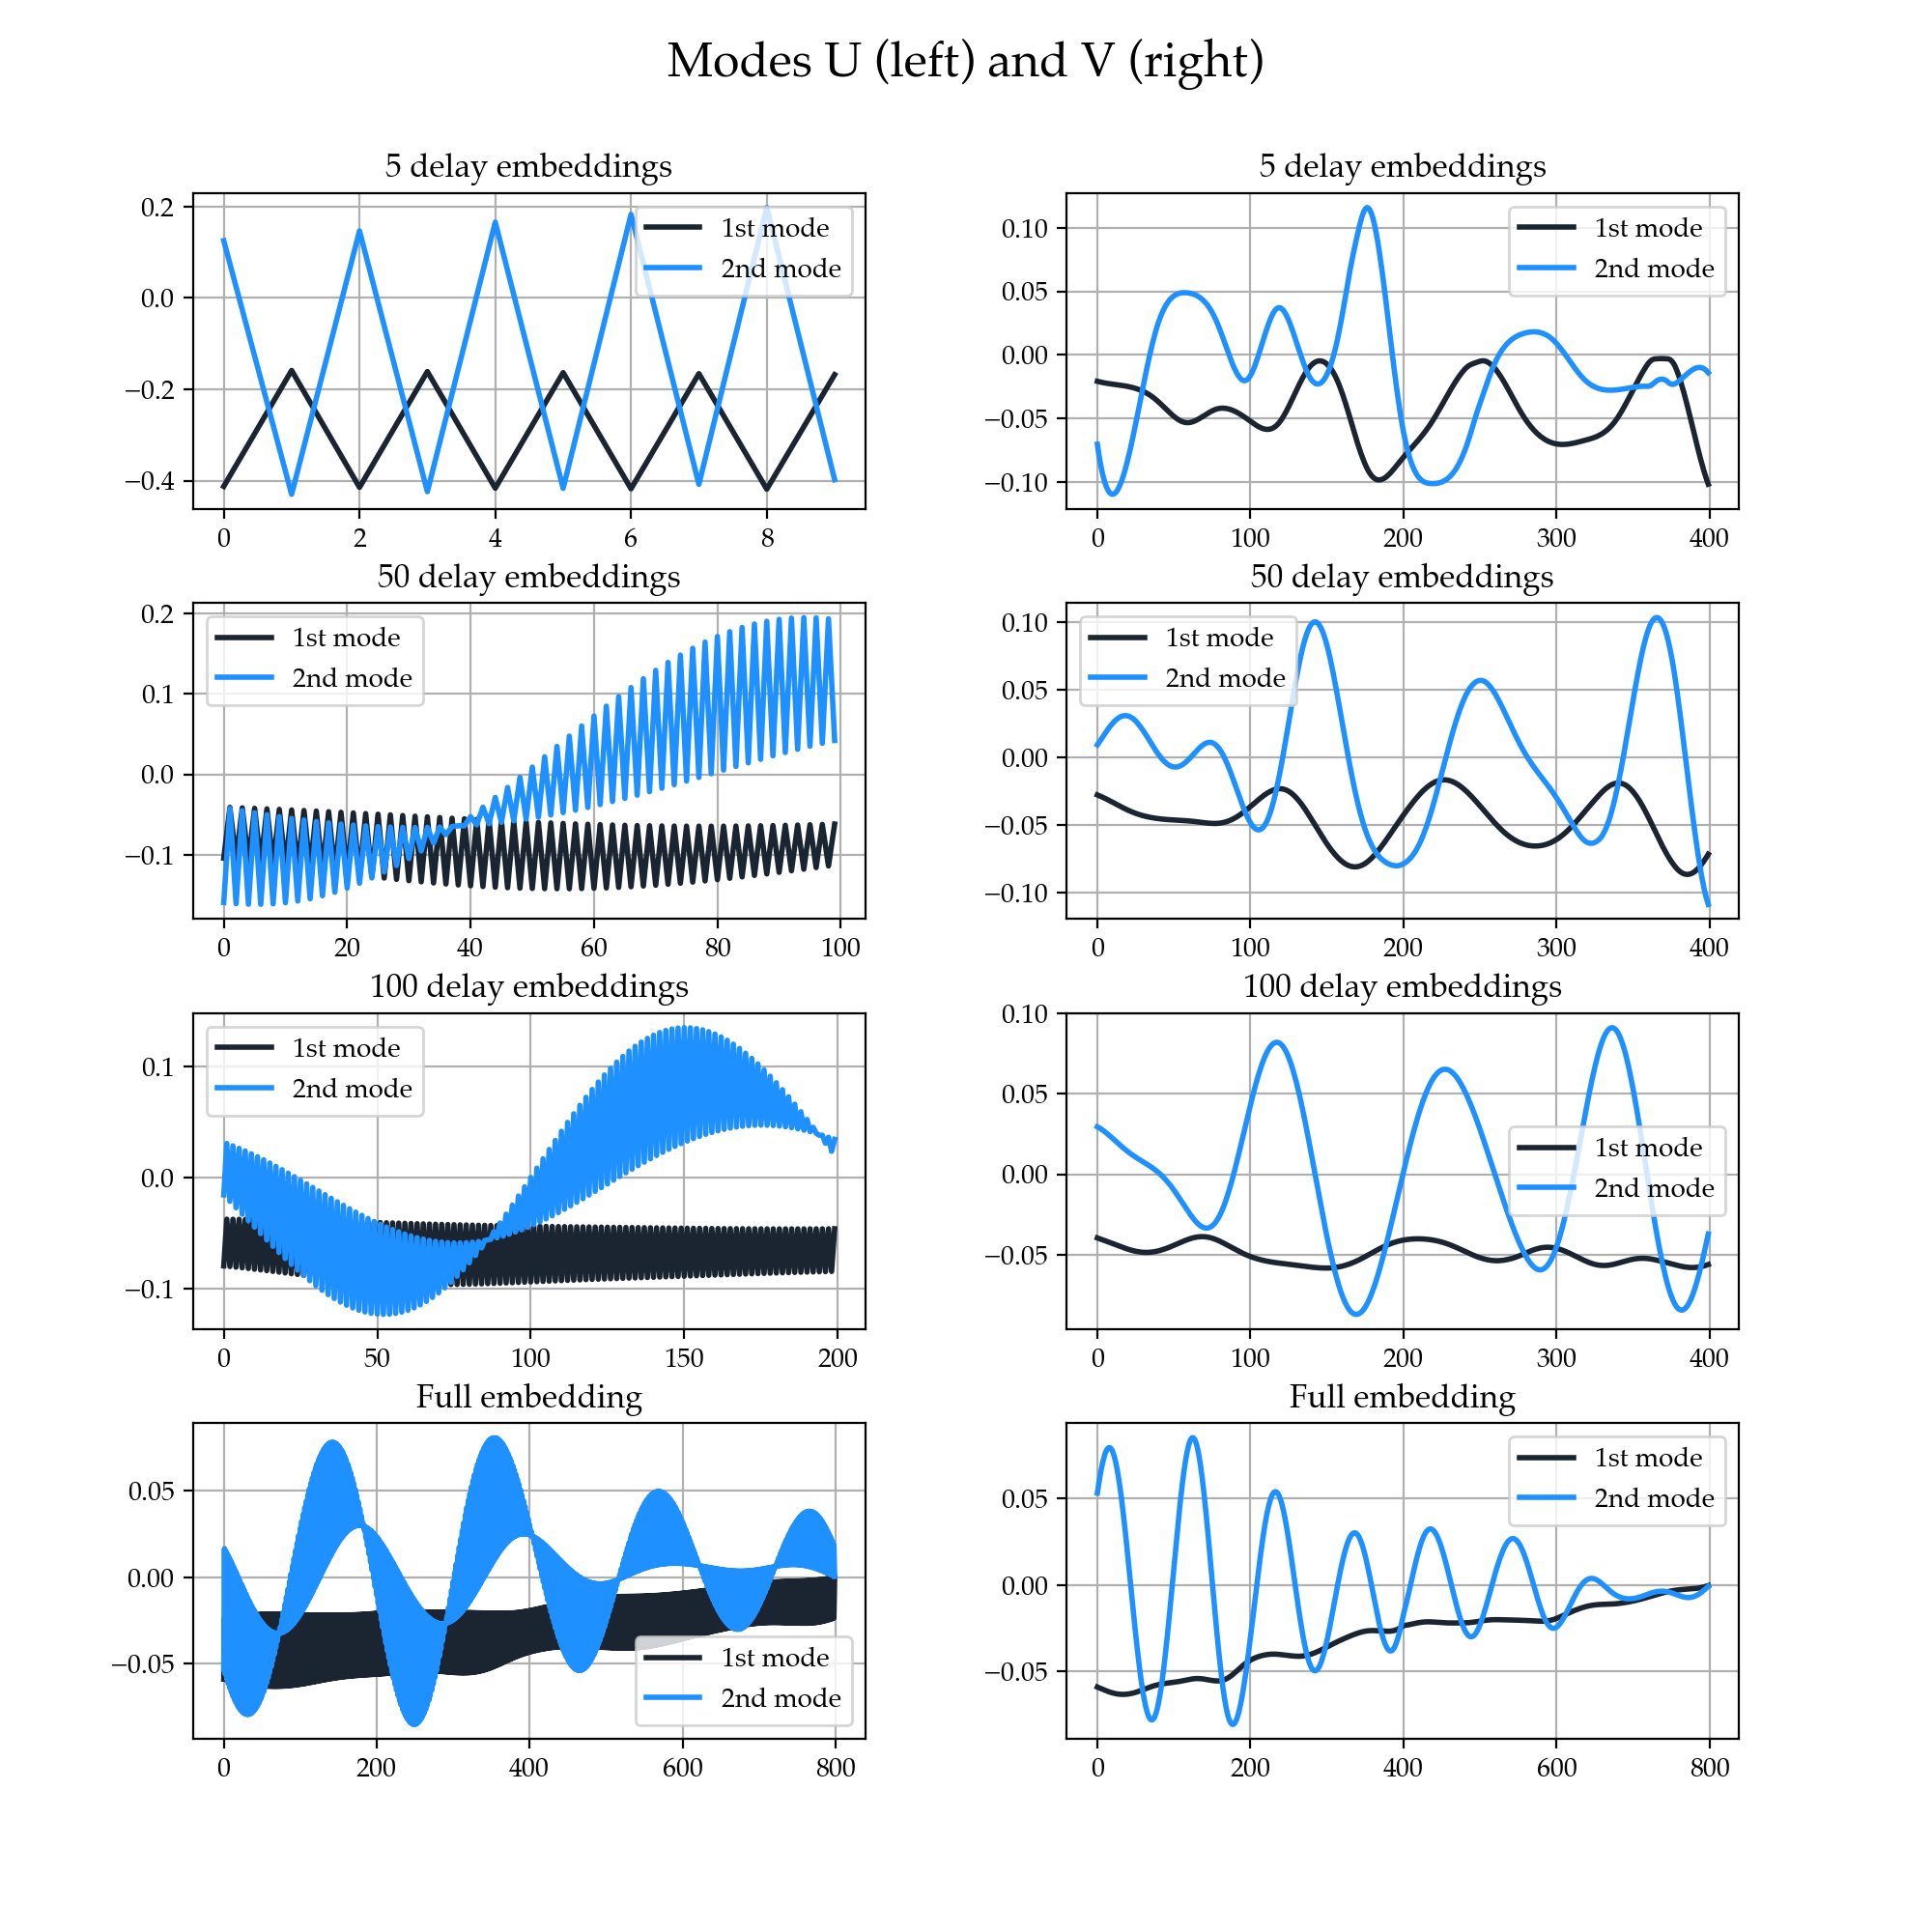

In [109]:
fig = plt.figure(figsize=(10, 10))
colors = ['xkcd:dark', 'dodgerblue', 'slategray']
gs = gridspec.GridSpec(4, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
fig.suptitle("Modes U (left) and V (right)", fontsize=18)

ax = plt.subplot(gs[0, 0])
h = ax.plot(U1[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U1[:, 1], linewidth='2', color=colors[1])
ax.set_title('5 delay embeddings', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[0, 1])
h = ax.plot(V1[0, :], linewidth='2', color=colors[0])
h = ax.plot(V1[1, :], linewidth='2', color=colors[1])
ax.set_title('5 delay embeddings', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.plot(U2[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U2[:, 1], linewidth='2', color=colors[1])
ax.set_title('50 delay embeddings', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[1, 1])
h = ax.plot(V2[0, :], linewidth='2', color=colors[0])
h = ax.plot(V2[1, :], linewidth='2', color=colors[1])
ax.set_title('50 delay embeddings', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

ax = plt.subplot(gs[2, 0])
h = ax.plot(U3[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U3[:, 1], linewidth='2', color=colors[1])
ax.set_title('100 delay embeddings', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[2, 1])
h = ax.plot(V3[0, :], linewidth='2', color=colors[0])
h = ax.plot(V3[1, :], linewidth='2', color=colors[1])
ax.set_title('100 delay embeddings', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

ax = plt.subplot(gs[3, 0])
h = ax.plot(U4[:, 0], linewidth='2', color=colors[0])
h = ax.plot(U4[:, 1], linewidth='2', color=colors[1])
ax.set_title('Full embedding', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()
ax = plt.subplot(gs[3, 1])
h = ax.plot(V4[0, :], linewidth='2', color=colors[0])
h = ax.plot(V4[1, :], linewidth='2', color=colors[1])
ax.set_title('Full embedding', fontsize = 12)
ax.legend(['1st mode', '2nd mode'], fontsize = 10)
ax.grid()

fig.savefig('figures/td_modes.svg', format='svg', dpi=1200)

In [106]:
r = 4
X = H1
dX = dH1
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T # general
U = U[:, :r]
V = V[:, :r]
S = S[:r]

A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
Lambda, W = np.linalg.eig(A_tilde)
Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W

X0 = X[:, 0] # initial conditions

omega = np.log(Lambda) / dt_new

b = np.linalg.pinv(Phi) @ X0

x_k = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b

x_dmd1 = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_dmd1[:, k] = np.dot(Phi,b * np.exp(omega*t_new[k]))
    
t_window = t_start
x_train = np.ones((100,)) * years_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

In [110]:
r = 10
X = H2
dX = dH2
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T # general
U = U[:, :r]
V = V[:, :r]
S = S[:r]

A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
Lambda, W = np.linalg.eig(A_tilde)
Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W

X0 = X[:, 0] # initial conditions

omega = np.log(Lambda) / dt_new

b = np.linalg.pinv(Phi) @ X0

x_k = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b

x_dmd2 = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_dmd2[:, k] = np.dot(Phi,b * np.exp(omega*t_new[k]))
    
t_window = t_start
x_train = np.ones((100,)) * years_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

In [111]:
r = 20
X = H3
dX = dH3
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T # general
U = U[:, :r]
V = V[:, :r]
S = S[:r]

A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
Lambda, W = np.linalg.eig(A_tilde)
Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W

X0 = X[:, 0] # initial conditions

omega = np.log(Lambda) / dt_new

b = np.linalg.pinv(Phi) @ X0

x_k = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b

x_dmd3 = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_dmd3[:, k] = np.dot(Phi,b * np.exp(omega*t_new[k]))
    
t_window = t_start
x_train = np.ones((100,)) * years_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

In [128]:
r = 40
X = H4
dX = dH4
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T # general
U = U[:, :r]
V = V[:, :r]
S = S[:r]

A_tilde = U.conj().T @ dX @ V @ np.linalg.inv(np.diag(S))
Lambda, W = np.linalg.eig(A_tilde)
Phi = dX @ V @ np.linalg.inv(np.diag(S)) @ W

X0 = X[:, 0] # initial conditions

omega = np.log(Lambda) / dt_new

b = np.linalg.pinv(Phi) @ X0

x_k = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_k[:, k] = Phi @ (np.diag(Lambda) ** (k)) @ b

x_dmd4 = np.zeros((X.shape[0], t_new.shape[0]), dtype=omega.dtype)
for k in range(t_new.shape[0]):
    x_dmd4[:, k] = np.dot(Phi,b * np.exp(omega*t_new[k]))
    
t_window = t_start
x_train = np.ones((100,)) * years_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

<IPython.core.display.Javascript object>


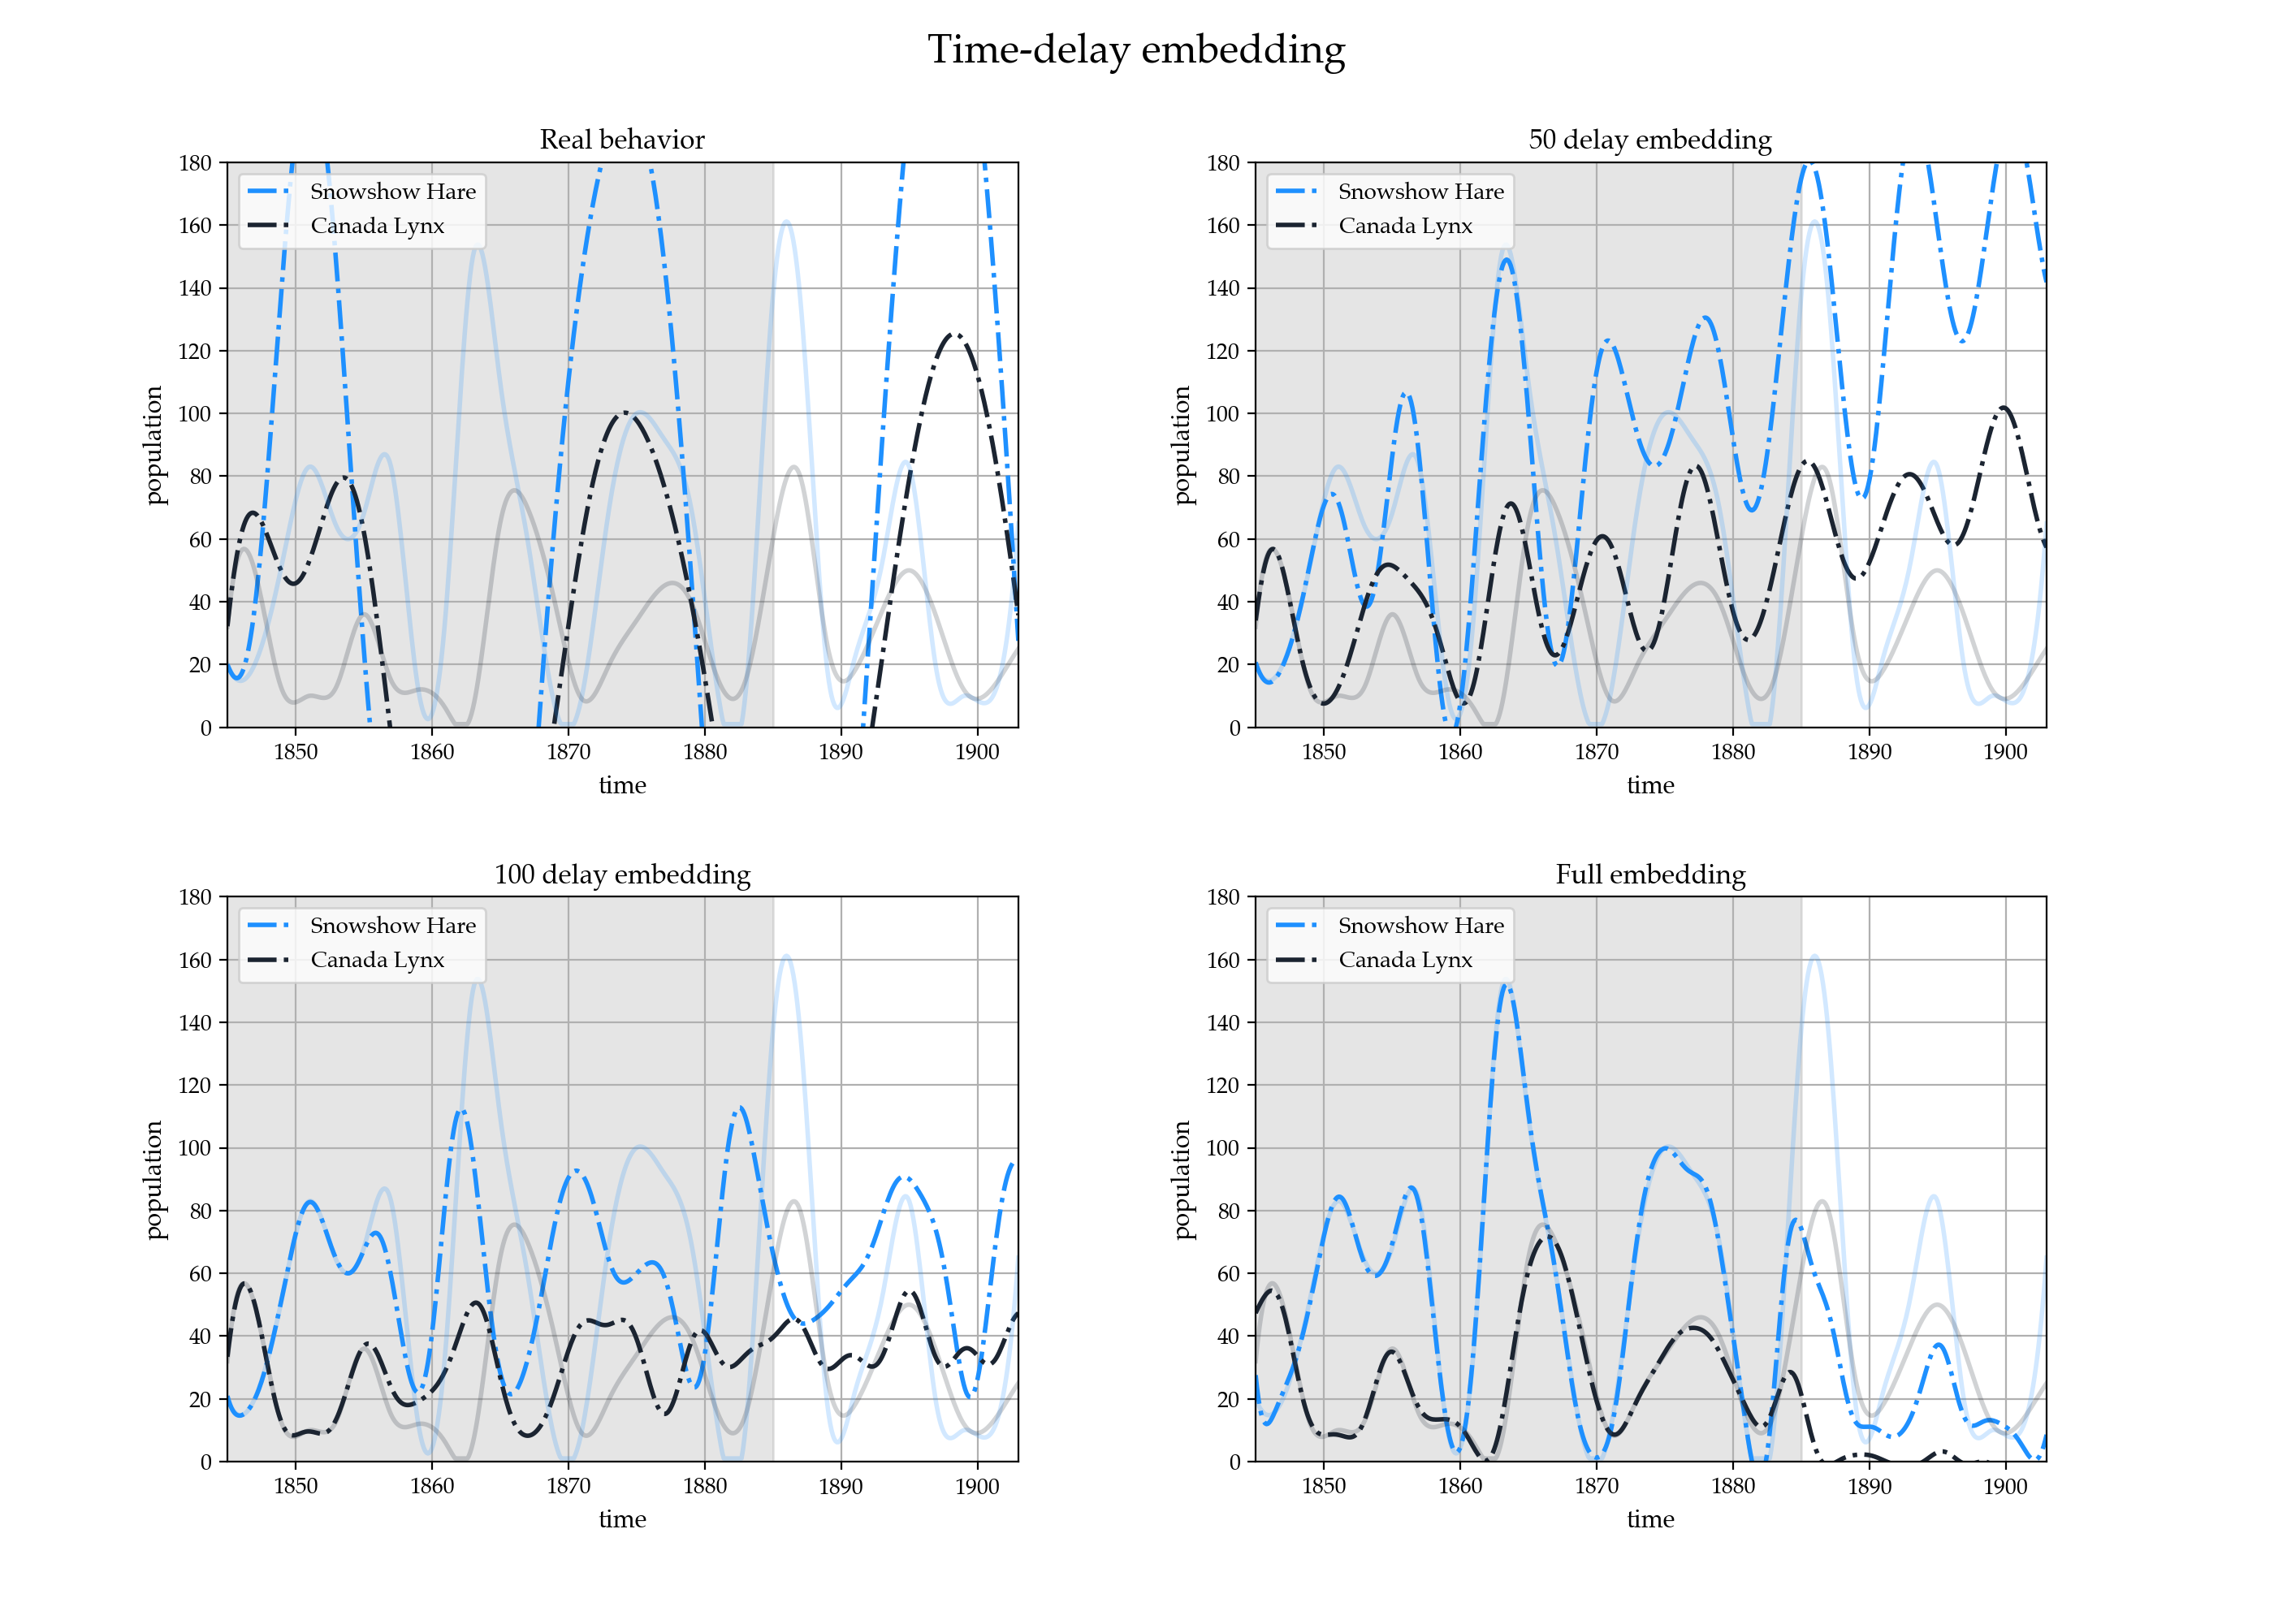

In [175]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle("Time-delay embedding", fontsize=18)

gs = gridspec.GridSpec(2, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:], np.real(x_dmd1[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd1[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1) 
ax.set_ylim([0, 180])
ax.set_title('Real behavior', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new[:], np.real(x_dmd2[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd2[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1)  
ax.set_ylim([0, 180])
ax.set_title('50 delay embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.plot(years_new[:], np.real(x_dmd3[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd3[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1)  
ax.set_ylim([0, 180])
ax.set_title('100 delay embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[1, 1])
h = ax.plot(years_new[:], np.real(x_dmd4[0, :]), '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], np.real(x_dmd4[1, :]), '-.', linewidth='2', color='xkcd:dark')
h = ax.plot(years_new[:], data[0, :], linewidth='2', color='dodgerblue', alpha=0.2)
h = ax.plot(years_new[:], data[1, :], linewidth='2', color='xkcd:dark', alpha=0.2)
h = ax.fill([0, years_new[t_window], years_new[t_window], 0], [-100, -100, 200, 200], color='k', alpha=0.1)  
ax.set_ylim([0, 180])
ax.set_title('Full embedding', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('population', fontsize = 11)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 10, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

fig.savefig('figures/td_dmd.pdf', format='pdf', dpi=1200)

## Part 3: Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.

In [ ]:
def rhs_lotkavolterra(x0, t, dummy, b, p, d, r):
    x, y = x0
    rhs = [b * x - p * x * y,
            -d * y + r * x * y]
    return rhs

In [ ]:
dt = dt_new
years = years_new
t = t_new
test_size = int(len(t) * 0.2)
x1 = SH_new[:-test_size]
x2 = CL_new[:-test_size]
x1_test = SH_new[-test_size:]
x2_test = CL_new[-test_size:]

In [ ]:
n = len(t) - test_size

noise = 0.

x1 = x1 + noise * np.random.randn(n,)
x2 = x2 + noise * np.random.randn(n,)

x1dot = [0] * (n - 2)
x2dot = [0] * (n - 2)

# center difference scheme
for i in range(1, n-1):
    x1dot[i-1] = (x1[i+1] - x1[i-1]) / (2 * dt)
    x2dot[i-1] = (x2[i+1] - x2[i-1]) / (2 * dt)
    
x1s = np.array(x1[1:-1])
x2s = np.array(x2[1:-1])

A1 = np.array([x1s, -x1s * x2s])
A2 = np.array([-x2s, x1s * x2s])
#A = np.array([x1s, x2s, x1s ** 2, x1s * x2s, x2s ** 2, x1s ** 3, (x1s ** 2) * x2s, (x2s ** 2) * x1s, x2s ** 3])

In [ ]:
#model1 = Ridge(alpha=0.1, max_iter=1e5)
model1 = LinearRegression()
model1.fit(A1.T, x1dot)
#model2 = Ridge(alpha=0.1, max_iter=1e5)
model2 = LinearRegression()
model2.fit(A2.T, x2dot)

In [ ]:
fig = plt.figure(figsize=(14, 5))
ax = [fig.add_subplot(1, 2, k) for k in range(1,3)]
#bar_name = ['0','x1', 'x2', 'x1^2', 'x1x1', 'x2^2', 'x1^3', 'x2^2x1', 'x2^3']
bar1_name = ['x1', '-x1 * x2']
bar2_name = ['-x2', 'x1 * x2']
ax[0].bar(bar1_name, model1.coef_, color='dodgerblue')
ax[1].bar(bar2_name, model2.coef_, color='xkcd:dark')
ax[0].grid()
ax[1].grid()
ax[0].set_title('Prey', fontsize = 18)
ax[1].set_title('Predator', fontsize = 18)
ax[0].set_ylabel('loading magnitude', fontsize = 14)
ax[1].set_ylabel('loading magnitude', fontsize = 14)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [ ]:
b, p, d, r = model1.coef_[0], model1.coef_[1], model2.coef_[0], model2.coef_[1]
print("Estimate for b: {}".format(b))
print("Estimate for p: {}".format(p))
print("Estimate for d: {}".format(d))
print("Estimate for r: {}".format(r))

In [ ]:
x0 = [x1[-1], x2[-1]]
t_test = np.arange(t[-test_size], t[-1], 0.1)
sol = integrate.odeint(rhs_lotkavolterra, x0, t_test, args=([], b, p, d, r), mxstep=10**8) # integrate PDE

In [ ]:
fig = plt.figure(figsize=(14, 7))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(t[-test_size:], x1_test, linewidth='2', color='dodgerblue')
h = ax.plot(t[-test_size:], x2_test, linewidth='2', color='xkcd:dark')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(t_test, sol[:, 0], '-.', linewidth='2', color='dodgerblue')
h = ax.plot(t_test, sol[:, 1], '-.', linewidth='2', color='xkcd:dark')
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.grid()

In [ ]:
x0 = [x1[0], x2[0]]
t_test = np.arange(t[0], t[-1], 0.1)
sol = integrate.odeint(rhs_lotkavolterra, x0, t_test, args=([], b, p, d, r), mxstep=10**8) # integrate PDE

In [ ]:
fig = plt.figure(figsize=(14, 7))

gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(years_new[:], SH_new, linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:], CL_new, linewidth='2', color='xkcd:dark')
ax.set_ylim([0, 200])
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(years_new[:-1], sol[:, 0], '-.', linewidth='2', color='dodgerblue')
h = ax.plot(years_new[:-1], sol[:, 1], '-.', linewidth='2', color='xkcd:dark')
h = ax.fill([0, years_new[-test_size], years_new[-test_size], 0], [-100, -100, 500, 500], color='k', alpha=0.1)  
ax.set_ylim([0, 400])
ax.set_title('Approximate behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12, loc='upper left')
ax.set_xlim([years_new[0], years_new[-1]])
ax.grid()

## Part 4: Find the best fit nonlinear, dynamical systems model to the data using sparse regression